# Mid-Program Project : Consumer Complaint Resolution

## 1. Import the libraries

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import sort_dataframeby_monthorweek
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
import string
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from scipy.stats import loguniform
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## 2. Load the data

In [2]:
df_train = pd.read_csv('Consumer_Complaints_train.csv')
df_test = pd.read_csv('Consumer_Complaints_test.csv')
df_train.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2015-10-14,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,NaN,Equifax,GA,30134,NaN,Consent not provided,Web,2015-10-14,Closed with explanation,Yes,No,1605653
1,2015-04-26,Bank account or service,Other bank product/service,Deposits and withdrawals,NaN,RE : XXXX XXXX XXXX-PRIVILEGED AND CONFIDENTIA...,NaN,Wells Fargo & Company,GA,319XX,NaN,Consent provided,Web,2015-04-26,Closed with explanation,Yes,Yes,1347613


## 3. Data Exploration

### 3. a. Missing values in the columns

--------------------------------------------------
Missing values by columns :

Date received                        0
Product                              0
Sub-product                     103786
Issue                                0
Sub-issue                       219374
Consumer complaint narrative    302630
Company public response         290879
Company                              0
State                             2903
ZIP code                          2911
Tags                            308584
Consumer consent provided?      257230
Submitted via                        0
Date sent to company                 0
Company response to consumer         0
Timely response?                     0
Consumer disputed?                   0
Complaint ID                         0
dtype: int64
--------------------------------------------------


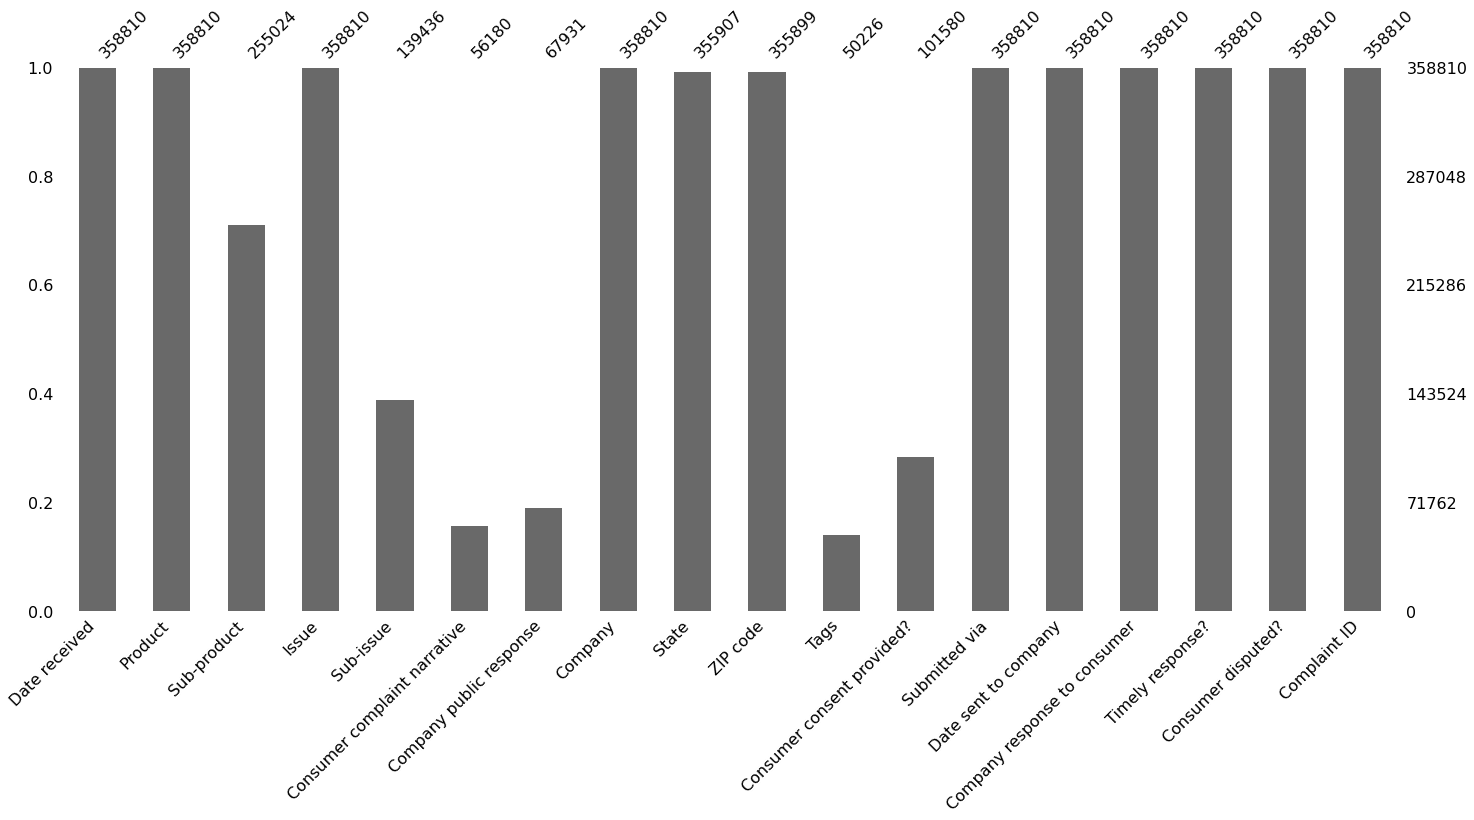

In [13]:
# Visualize the number of missing values as a bar chart 
msno.bar(df_train)

missing_values = df_train.isna().sum()
print('-' * 50)
print('Missing values by columns :\n')
print(missing_values)
print('-' * 50)

**We can see a lot of text & categorical columns which are containing many missing values**

### 3. b. Unique values and most frequently occuring categories in Categorical Columns

--------------------------------------------------
Unique categories in Product :

Mortgage                   117066
Debt collection             65033
Credit reporting            60672
Credit card                 43114
Bank account or service     40667
Consumer Loan               13964
Student loan                11306
Money transfers              2502
Payday loan                  2425
Prepaid card                 1671
Other financial service       385
Virtual currency                5
Name: Product, dtype: int64
--------------------------------------------------


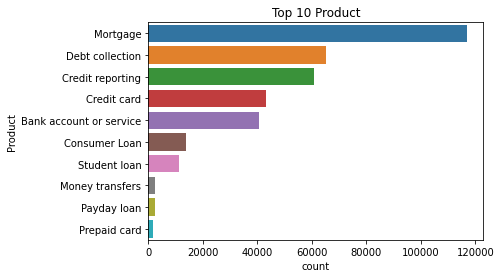

--------------------------------------------------
Unique categories in Sub-product :

Other mortgage                            46174
Conventional fixed mortgage               35954
Checking account                          28708
Other (i.e. phone, health club, etc.)     19297
I do not know                             13601
Credit card                               13582
Conventional adjustable mortgage (ARM)    13175
FHA mortgage                              12221
Non-federal student loan                  11579
Medical                                    8612
Vehicle loan                               8006
Other bank product/service                 7321
Payday loan                                5894
Home equity loan or line of credit         5724
Installment loan                           3616
Savings account                            2549
VA mortgage                                2448
Mortgage                                   2308
(CD) Certificate of deposit                1781
A

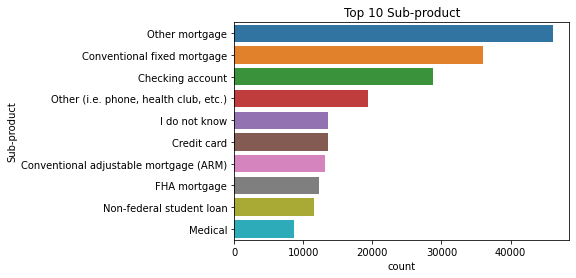

--------------------------------------------------
Unique categories in Issue :

Loan modification,collection,foreclosure    60185
Incorrect information on credit report      43825
Loan servicing, payments, escrow account    38456
Cont'd attempts collect debt not owed       27266
Account opening, closing, or management     17557
                                            ...  
Lost or stolen check                           14
Incorrect exchange rate                        12
Lender damaged or destroyed vehicle             3
Lender sold the property                        2
Lender damaged or destroyed property            1
Name: Issue, Length: 95, dtype: int64
--------------------------------------------------


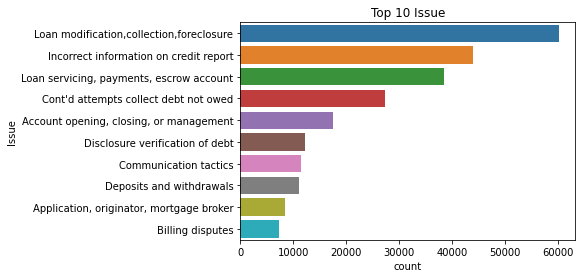

--------------------------------------------------
Unique categories in Sub-issue :

Account status                              17142
Debt is not mine                            16772
Information is not mine                     13199
Not given enough info to verify debt         8451
Debt was paid                                7372
                                            ...  
Receiving unwanted marketing/advertising      112
Contacted me instead of my attorney           104
Received marketing offer after opted out       87
Report shared with employer w/o consent        82
Qualify for a better loan than offered         65
Name: Sub-issue, Length: 67, dtype: int64
--------------------------------------------------


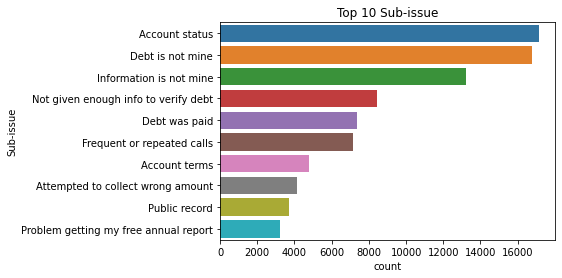

--------------------------------------------------
Unique categories in Company :

Bank of America                        34903
Wells Fargo & Company                  26490
JPMorgan Chase & Co.                   21677
Equifax                                21489
Experian                               20075
                                       ...  
DMA Financial Corp.                        1
Priority Financial Network                 1
Account Control Services, Inc              1
Developer's Mortgage Company               1
Universal Technical Institute, Inc.        1
Name: Company, Length: 3064, dtype: int64
--------------------------------------------------


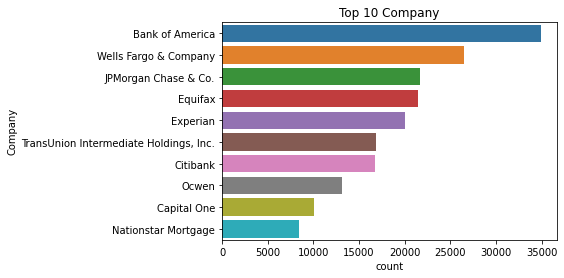

--------------------------------------------------
Unique categories in State :

CA    52368
FL    34567
TX    26683
NY    24554
GA    15886
      ...  
MH       19
MP       13
AS        9
PW        8
AA        7
Name: State, Length: 62, dtype: int64
--------------------------------------------------


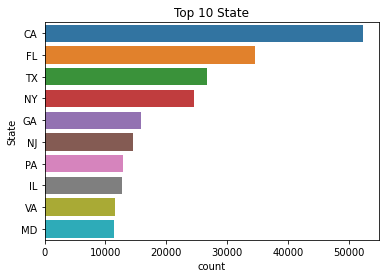

--------------------------------------------------
Unique categories in Tags :

Older American                   29253
Servicemember                    16872
Older American, Servicemember     4101
Name: Tags, dtype: int64
--------------------------------------------------


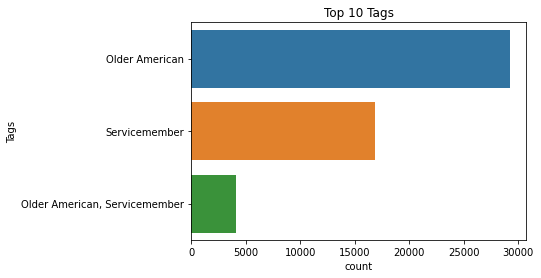

--------------------------------------------------
Unique categories in Consumer consent provided? :

Consent provided        56181
Consent not provided    42186
Other                    3211
Consent withdrawn           2
Name: Consumer consent provided?, dtype: int64
--------------------------------------------------


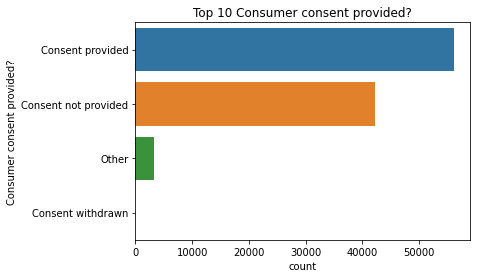

--------------------------------------------------
Unique categories in Submitted via :

Web            235462
Referral        68450
Phone           25802
Postal mail     23644
Fax              5264
Email             188
Name: Submitted via, dtype: int64
--------------------------------------------------


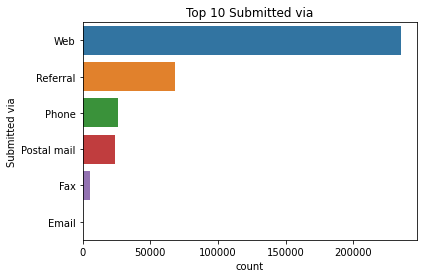

--------------------------------------------------
Unique categories in Company response to consumer :

Closed with explanation            265700
Closed with non-monetary relief     46085
Closed with monetary relief         24715
Closed without relief               10604
Closed                               8568
Closed with relief                   3138
Name: Company response to consumer, dtype: int64
--------------------------------------------------


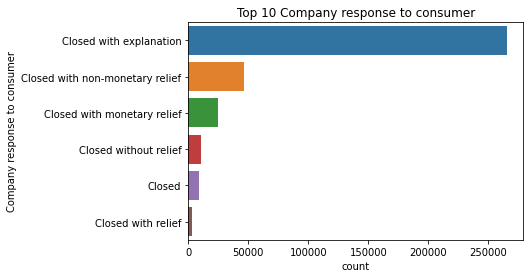

--------------------------------------------------
Unique categories in Timely response? :

Yes    352675
No       6135
Name: Timely response?, dtype: int64
--------------------------------------------------


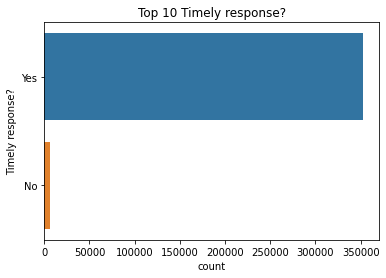

--------------------------------------------------
Unique categories in Consumer disputed? :

No     282638
Yes     76172
Name: Consumer disputed?, dtype: int64
--------------------------------------------------


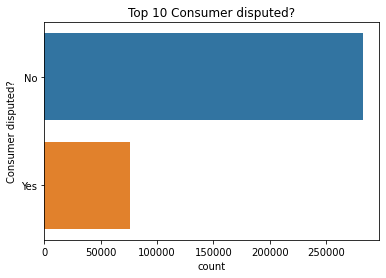

In [37]:
cols = ['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Company',
        'State', 'Tags', 'Consumer consent provided?', 'Submitted via',
        'Company response to consumer', 'Timely response?', 'Consumer disputed?']
for col in cols:
    if df_train[col].dtype == 'object':
        unique_values = df_train[col].value_counts()
        print('-' * 50)
        print(f'Unique categories in {col} :\n')
        print(unique_values)
        print('-' * 50)
        plt.figure()
        sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index[: 10]).set_title(f'Top 10 {col}')
        plt.show()

### 3. c. Top issues raised

--------------------------------------------------
Unique categories in Issue :

Loan modification,collection,foreclosure    60185
Incorrect information on credit report      43825
Loan servicing, payments, escrow account    38456
Cont'd attempts collect debt not owed       27266
Account opening, closing, or management     17557
                                            ...  
Lost or stolen check                           14
Incorrect exchange rate                        12
Lender damaged or destroyed vehicle             3
Lender sold the property                        2
Lender damaged or destroyed property            1
Name: Issue, Length: 95, dtype: int64
--------------------------------------------------


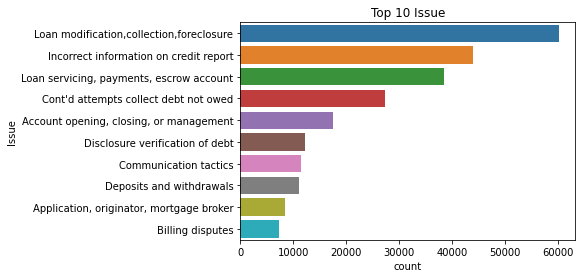

In [38]:
col = 'Issue'
unique_values = df_train[col].value_counts()
print('-' * 50)
print(f'Unique categories in {col} :\n')
print(unique_values)
print('-' * 50)
plt.figure()
sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index[: 10]).set_title(f'Top 10 {col}')
plt.show()

- **'Loan modification, collection, foreclosure' is the top issue raised by consumers followed by 'Incorrect information on credit report' and 'Loan servicing, payments, escrow account'**
- **Top issues seems to be with loans & credit issues**

### 3. d. Products receiving high complaints

--------------------------------------------------
Unique categories in Product :

Mortgage                   117066
Debt collection             65033
Credit reporting            60672
Credit card                 43114
Bank account or service     40667
Consumer Loan               13964
Student loan                11306
Money transfers              2502
Payday loan                  2425
Prepaid card                 1671
Other financial service       385
Virtual currency                5
Name: Product, dtype: int64
--------------------------------------------------


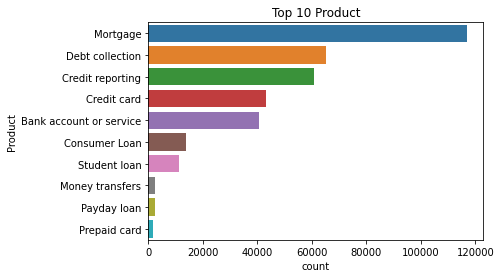

In [39]:
col = 'Product'
unique_values = df_train[col].value_counts()
print('-' * 50)
print(f'Unique categories in {col} :\n')
print(unique_values)
print('-' * 50)
plt.figure()
sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index[: 10]).set_title(f'Top 10 {col}')
plt.show()

- **Top products with high complaints include Mortgage, Debt collection, Credit reporting, Credit card**
- **These products match with the top issues raised by the consumers**

### 3. e. Complaints received by companies

--------------------------------------------------
Unique categories in Company :

Bank of America                             34903
Wells Fargo & Company                       26490
JPMorgan Chase & Co.                        21677
Equifax                                     21489
Experian                                    20075
                                            ...  
Signature Performance Tiburon, LLC              1
USA Service Finance LLC                         1
Patriot Mortgage Corporation                    1
HighTechLending, Inc.                           1
Rosebud Economic Development Corporation        1
Name: Company, Length: 3064, dtype: int64
--------------------------------------------------


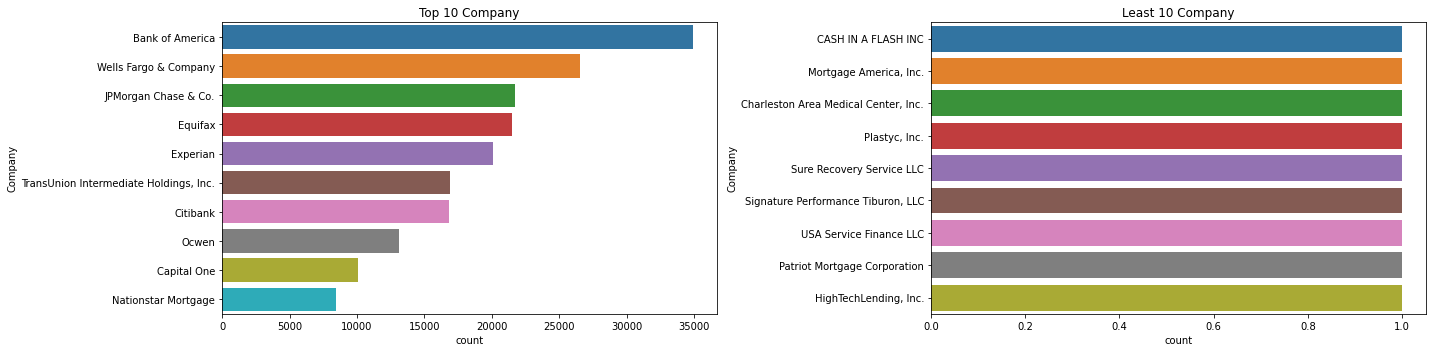

In [83]:
col = 'Company'
unique_values = df_train[col].value_counts()
print('-' * 50)
print(f'Unique categories in {col} :\n')
print(unique_values)
print('-' * 50)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index[: 10], ax=ax[0]).set_title(f'Top 10 {col}')
sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index[-10: -1], ax=ax[1]).set_title(f'Least 10 {col}')
plt.tight_layout()
fig.show()

- **We can see that not all companies are receiving the same number of complaints**
- **Top financial companies like Bank of America, Wells Fargo & Company, JPMorgan Chase & Co. are receiving higher number of complaints**
- **Number of least complaints registered by many companies are 1**

### 3. f. Submission medium

--------------------------------------------------
Unique categories in Submitted via :

Web            235462
Referral        68450
Phone           25802
Postal mail     23644
Fax              5264
Email             188
Name: Submitted via, dtype: int64
--------------------------------------------------


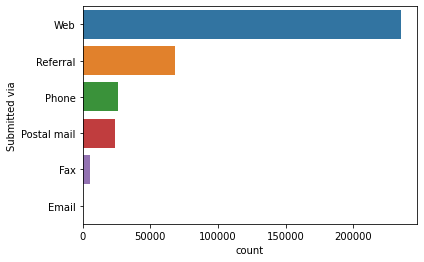

In [42]:
col = 'Submitted via'
unique_values = df_train[col].value_counts()
print('-' * 50)
print(f'Unique categories in {col} :\n')
print(unique_values)
print('-' * 50)
plt.figure()
sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index[: 10])
plt.show()

- **Complaints are submitted through multiple mediums like Web, Referral, Phone, Mails & Fax**
- **Most of the consumers prefer to submit their complaints via Web**

### 3. g. Geographical distribution of complaints

--------------------------------------------------
Unique categories in State :

CA    52368
FL    34567
TX    26683
NY    24554
GA    15886
      ...  
MH       19
MP       13
AS        9
PW        8
AA        7
Name: State, Length: 62, dtype: int64
--------------------------------------------------


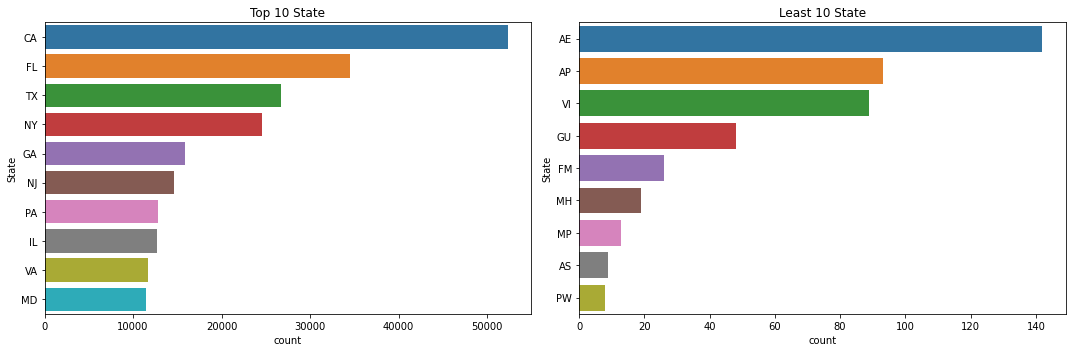

In [85]:
col = 'State'
unique_values = df_train[col].value_counts()
print('-' * 50)
print(f'Unique categories in {col} :\n')
print(unique_values)
print('-' * 50)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index[: 10], ax=ax[0]).set_title(f'Top 10 {col}')
sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index[-10: -1], ax=ax[1]).set_title(f'Least 10 {col}')
plt.tight_layout()
fig.show()

- **Complaints received by different states are varying in numbers**
- **California, Florida & Texas consumers complaints are more in number**
- **States like Palau, American Samoa, Northern Marianas are receiving very few complaints**

### 3. h. Rise of complaints in specific month or day of the week

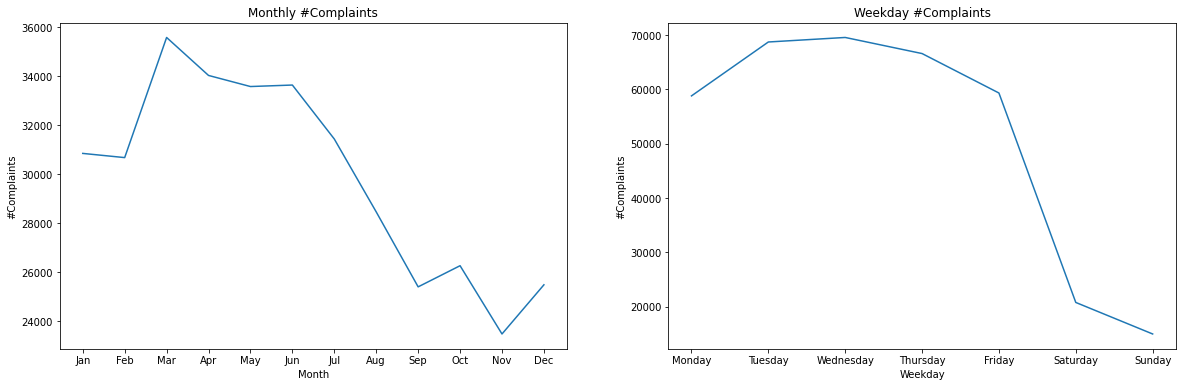

In [86]:
df_train['Date received'] = pd.to_datetime(df_train['Date received'])
df_train['Month'] = df_train['Date received'].dt.strftime('%b')
df_train['Weekday'] = df_train['Date received'].dt.strftime("%A")

df_mon = df_train.groupby('Month').agg({'Date received': 'count'}).reset_index()
df_mon = sort_dataframeby_monthorweek.Sort_Dataframeby_Month(df=df_mon, monthcolumnname='Month')
df_week = df_train.groupby('Weekday').agg({'Date received': 'count'}).reset_index()
df_week = sort_dataframeby_monthorweek.Sort_Dataframeby_Weekday(df=df_week, Weekdaycolumnname='Weekday')

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.lineplot(x='Month', y='Date received', sort=False, data=df_mon, ax=ax[0]).set(title='Monthly #Complaints', ylabel='#Complaints')
sns.lineplot(x='Weekday', y='Date received', sort=False, data=df_week, ax=ax[1]).set(title='Weekday #Complaints', ylabel='#Complaints')
fig.show()

- **Peak #complaints is attained in March, thereby we observe a decrease in #complaints till November and again slowly starts raising till March**
- **Complaints are more during weekdays compared to weekends**

### 3. i. Companies common responses

--------------------------------------------------
Unique categories in Company response to consumer :

Closed with explanation            265700
Closed with non-monetary relief     46085
Closed with monetary relief         24715
Closed without relief               10604
Closed                               8568
Closed with relief                   3138
Name: Company response to consumer, dtype: int64
--------------------------------------------------


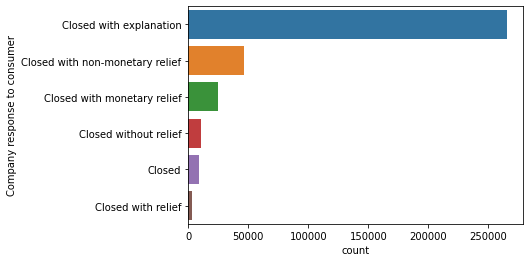

In [46]:
col = 'Company response to consumer'
unique_values = df_train[col].value_counts()
print('-' * 50)
print(f'Unique categories in {col} :\n')
print(unique_values)
print('-' * 50)
plt.figure()
sns.countplot(y=col, data=df_train, order=df_train[col].value_counts().index[: 10])
plt.show()

- **We can see that broadly there are 6 response categories**
- **Most of the responses received are 'Closed with explanation'**

### 3. j. Timely Response vs Consumers Disputed

--------------------------------------------------
Timely Response vs Consumers Disputed

Consumer disputed?      No    Yes
Timely response?                 
No                    4906   1229
Yes                 277732  74943
--------------------------------------------------


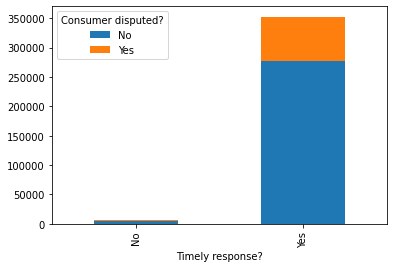

In [92]:
ct = pd.crosstab(df_train['Timely response?'], df_train['Consumer disputed?'])
print('-' * 50)
print('Timely Response vs Consumers Disputed\n')
print(ct)
print('-' * 50)
ct.plot.bar(stacked=True)

- **20% of consumers disputed when there was no timely response given by the companies**
- **21% of consumers disputed when there was a timely response given by the companies**
- **There seems to be equal number of consumer disputes irrespective of timely responses given by the companies**

## 4. Text Based Modeling

### 4. a. Preparing the dataset
- Choosing the columns required to predict the type of product identified in the complaint
- We need to remove NAs from Product & Consumer complaint narrative column before attempting to build a Text Classifier

In [93]:
df_predict_product = df_train[['Product', 'Consumer complaint narrative']]
df_predict_product = df_predict_product.dropna().reset_index(drop=True)
df_predict_product.head(2)

,Product,Consumer complaint narrative
0,Bank account or service,RE : XXXX XXXX XXXX-PRIVILEGED AND CONFIDENTIA...
1,Mortgage,Homeowner applied for 2nd modification due to ...


### 4. b. i. Text - preprocessing of train data
- TOKENIZATION --- sepearte each sentences into words
- STOPWORDS --- remove unimportant words
- PUNCTUATION --- remove punctuations
- STEMMING --- stem suffixes of a word (Riding --- ride, going --- go, helps -- help)
- LEMMATIZATION --- converting every word to its root word
- Preprocessing has to be on case by case basis. The more we customise data handling, the better it gets

In [94]:
# Consumer complaint narrative preprocessing
stop = set(stopwords.words('english'))

df_predict_product['narrative_preprocessed'] = df_predict_product['Consumer complaint narrative'].str.lower()
df_predict_product['narrative_preprocessed'] = df_predict_product['narrative_preprocessed'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df_predict_product['narrative_preprocessed'] = df_predict_product['narrative_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

df_predict_product['narrative_preprocessed'] = df_predict_product['narrative_preprocessed'].apply(lemmatize_text)

X_train = df_predict_product['narrative_preprocessed']
y_train = df_predict_product['Product']

df_predict_product.head()

,Product,Consumer complaint narrative,narrative_preprocessed
0,Bank account or service,RE : XXXX XXXX XXXX-PRIVILEGED AND CONFIDENTIA...,xxxx xxxx xxxxprivileged confidential informat...
1,Mortgage,Homeowner applied for 2nd modification due to ...,homeowner applied 2nd modification due reset f...
2,Debt collection,In XXXX I started service with a cable company...,xxxx started service cable company named xxxx ...
3,Consumer Loan,I went into a XXXX dealership and was told I w...,went xxxx dealership told would receive rate 9...
4,Debt collection,"When requested, Portfolio Recovery Services ( ...",requested portfolio recovery service pr claime...


### 4. b. ii. Text - preprocessing of test data

In [95]:
df_test_product = df_test[['Product', 'Consumer complaint narrative']]
df_test_product = df_test_product.dropna().reset_index(drop=True)

# Consumer complaint narrative preprocessing of test data
stop = set(stopwords.words('english'))

df_test_product['narrative_preprocessed'] = df_test_product['Consumer complaint narrative'].str.lower()
df_test_product['narrative_preprocessed'] = df_test_product['narrative_preprocessed'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df_test_product['narrative_preprocessed'] = df_test_product['narrative_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

df_test_product['narrative_preprocessed'] = df_test_product['narrative_preprocessed'].apply(lemmatize_text)

X_test = df_predict_product['narrative_preprocessed']
y_test = df_predict_product['Product']

df_test_product.head()

,Product,Consumer complaint narrative,narrative_preprocessed
0,Credit card,I WANT TO REQUEST A CREDIT LINE INCREASE OF XX...,want request credit line increase xxxx fell ri...
1,Consumer Loan,I have asked One Main Financial not to call my...,asked one main financial call place employment...
2,Debt collection,I have received several calls from a XXXX XXXX...,received several call xxxx xxxx summit receiva...
3,Credit reporting,I have contacted Experian and told them to rem...,contacted experian told remove erroneous addre...
4,Mortgage,The bank obtained the property through a forec...,bank obtained property foreclosure best knowle...


### 4. c. Modeling
- We can create features using the above preprocessed column using CountVectorizer or TF-IDF
- We will try 3 classifiers - MultinomialNB, SGDClassifier & Logistic Regression

In [129]:
%%time
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=df_test_product['Product'].unique().tolist()))

accuracy 0.713189747241011
                         precision    recall  f1-score   support

            Credit card       0.91      0.41      0.57      4875
          Consumer Loan       0.97      0.05      0.10      3104
        Debt collection       0.82      0.56      0.67      6659
       Credit reporting       0.86      0.80      0.83     10670
               Mortgage       0.64      0.94      0.76     14402
Other financial service       0.00      0.00      0.00       543
Bank account or service       0.66      0.97      0.79     12244
           Prepaid card       0.00      0.00      0.00        96
           Student loan       0.00      0.00      0.00       604
            Payday loan       0.00      0.00      0.00       608
        Money transfers       0.96      0.05      0.09      2371
       Virtual currency       0.00      0.00      0.00         4

               accuracy                           0.71     56180
              macro avg       0.49      0.32      0.32     56

In [131]:
%%time
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=df_test_product['Product'].unique().tolist()))

accuracy 0.8109825560697758
                         precision    recall  f1-score   support

            Credit card       0.80      0.77      0.78      4875
          Consumer Loan       0.88      0.40      0.55      3104
        Debt collection       0.77      0.77      0.77      6659
       Credit reporting       0.81      0.83      0.82     10670
               Mortgage       0.79      0.89      0.84     14402
Other financial service       0.91      0.24      0.37       543
Bank account or service       0.85      0.96      0.90     12244
           Prepaid card       0.00      0.00      0.00        96
           Student loan       0.89      0.05      0.10       604
            Payday loan       0.87      0.15      0.26       608
        Money transfers       0.90      0.71      0.79      2371
       Virtual currency       0.00      0.00      0.00         4

               accuracy                           0.81     56180
              macro avg       0.70      0.48      0.51     5

In [96]:
%%time
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=df_test_product['Product'].unique().tolist()))

accuracy 0.9318084727661089
                         precision    recall  f1-score   support

            Credit card       0.93      0.91      0.92      4875
          Consumer Loan       0.89      0.86      0.87      3104
        Debt collection       0.92      0.91      0.91      6659
       Credit reporting       0.93      0.95      0.94     10670
               Mortgage       0.92      0.93      0.93     14402
Other financial service       0.93      0.81      0.87       543
Bank account or service       0.97      0.98      0.97     12244
           Prepaid card       0.94      0.35      0.52        96
           Student loan       0.86      0.84      0.85       604
            Payday loan       0.86      0.95      0.90       608
        Money transfers       0.96      0.94      0.95      2371
       Virtual currency       1.00      0.75      0.86         4

               accuracy                           0.93     56180
              macro avg       0.93      0.85      0.87     5

Text(0.5, 33.0, 'Predicted label')

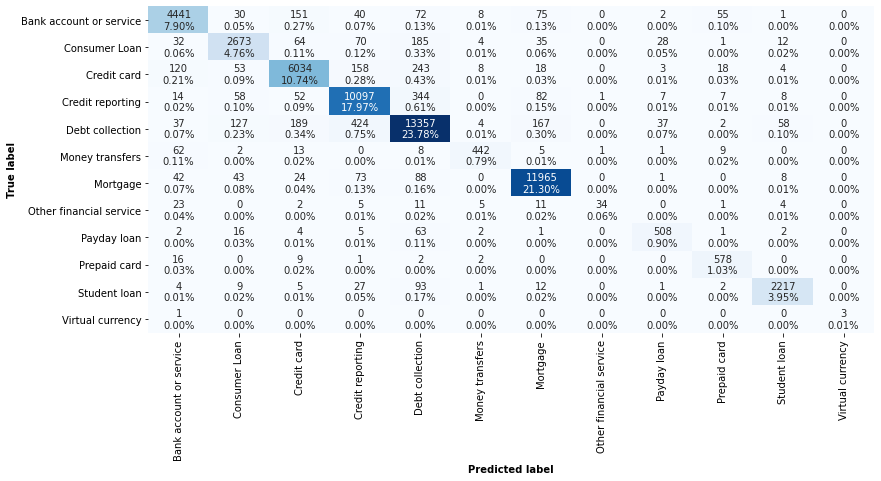

In [113]:
# Get & plot the confusion matrix for best model (logistic regression)
plt.figure(figsize = (13, 6))
cm = confusion_matrix(y_test, y_pred)
cm = np.int0(cm)
cls_labels = list(np.unique(y_test))
cmdf = pd.DataFrame(cm, index=cls_labels, columns=cls_labels)
cmdf = cmdf.round()
all_values = cm.ravel()
group_percentages = ["{0:.2%}".format(value/np.sum(all_values)) for value in all_values]
labels = [f"{v2}\n{v3}" for v2, v3 in zip(all_values,group_percentages)]
labels = np.array(labels).reshape(12, 12) 
sns.heatmap(cmdf, annot=labels, fmt='' ,cbar=False, cmap = 'Blues')
plt.ylabel('True label', **axis_font)
plt.xlabel('Predicted label', **axis_font)

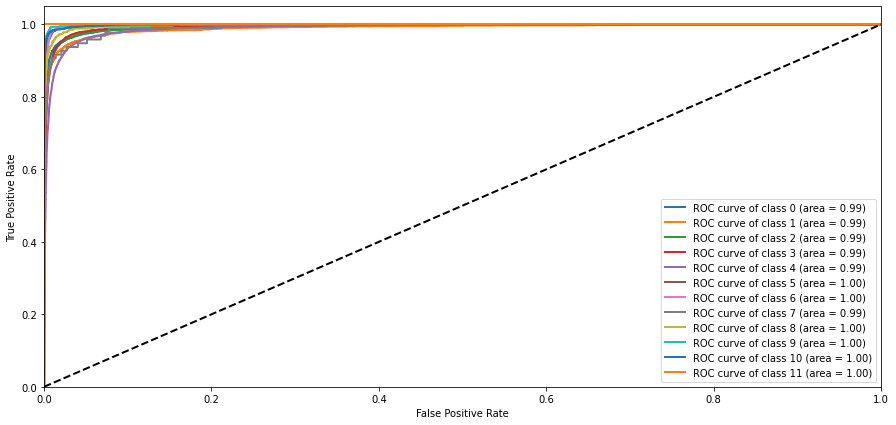

In [121]:
# AUC-ROC curve
predicted_probs = logreg.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

actuals_encoded = label_binarize(y_test, classes=np.unique(y_test))

for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(actuals_encoded[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (15, 7))

for i in range(12):
    plt.plot(fpr[i], tpr[i],
        lw=2,
        label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### 4. d. Results
- MultinomialNB gave an accuracy of 0.71 & finished processing in 9 sec
- SGDClassifier gave an accuracy of 0.81 & finished processing in 22 sec
- Logistic Regression gave an accuracy of 0.93 & finished processing in 340 sec
- We can see that Logistic Regression out-performed other classifiers interms of accuracy but has taken more computation time

## 5. Feature Engineering, Model Training & Evaluation
- Now we'll build a model to predict whether the consumer will dispute the resolution of the complaint or not

### 5. a. i. Imputing null values in train data

In [122]:
df_train['Date received'] = pd.to_datetime(df_train['Date received'])
df_train['Date sent to company'] = pd.to_datetime(df_train['Date sent to company'])

df_train['Sub-product'].fillna('Not Provided',inplace=True)
df_train['Sub-issue'].fillna('Not Provided',inplace=True)
df_train['Consumer complaint narrative'].fillna('None or Not Provided',inplace=True)
df_train['Company public response'].fillna('Company chooses not to provide',inplace=True)
df_train['Issue'].fillna('Other',inplace=True)
df_train['Tags'].fillna('Unknown',inplace=True)
df_train['Submitted via'].fillna('Other',inplace=True)
df_train['Consumer consent provided?'].fillna('Consent not provided',inplace=True) 
df_train['Consumer consent provided?']=df_train['Consumer consent provided?'].apply(lambda x: 
            'Consent not provided' if x=='Other' or x=='Consent withdrawn' else x)
df_train['State'].fillna('Not provided',inplace=True)
df_train['ZIP code'].fillna('Not Provided',inplace=True)
df_train.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2015-10-14,Credit reporting,Not Provided,Incorrect information on credit report,Information is not mine,None or Not Provided,Company chooses not to provide,Equifax,GA,30134,Unknown,Consent not provided,Web,2015-10-14,Closed with explanation,Yes,No,1605653
1,2015-04-26,Bank account or service,Other bank product/service,Deposits and withdrawals,Not Provided,RE : XXXX XXXX XXXX-PRIVILEGED AND CONFIDENTIA...,Company chooses not to provide,Wells Fargo & Company,GA,319XX,Unknown,Consent provided,Web,2015-04-26,Closed with explanation,Yes,Yes,1347613


### 5. a. ii. Imputing null values in test data

In [4]:
df_test['Date received'] = pd.to_datetime(df_train['Date received'])
df_test['Date sent to company'] = pd.to_datetime(df_train['Date sent to company'])

df_test['Sub-product'].fillna('Not Provided',inplace=True)
df_test['Sub-issue'].fillna('Not Provided',inplace=True)
df_test['Consumer complaint narrative'].fillna('None or Not Provided',inplace=True)
df_test['Company public response'].fillna('Company chooses not to provide',inplace=True)
df_test['Issue'].fillna('Other',inplace=True)
df_test['Tags'].fillna('Unknown',inplace=True)
df_test['Submitted via'].fillna('Other',inplace=True)
df_test['Consumer consent provided?'].fillna('Consent not provided',inplace=True) 
df_test['Consumer consent provided?']=df_test['Consumer consent provided?'].apply(lambda x: 
            'Consent not provided' if x=='Other' or x=='Consent withdrawn' else x)
df_test['State'].fillna('Not provided',inplace=True)
df_test['ZIP code'].fillna('Not Provided',inplace=True)
df_test.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID
0,2015-10-14,Credit card,Not Provided,Customer service / Customer relations,Not Provided,None or Not Provided,Company chooses not to provide,Citibank,TX,75241,Unknown,Consent not provided,Web,2015-10-14,Closed with monetary relief,Yes,1198133
1,2015-04-26,Consumer Loan,Title loan,Payment to acct not credited,Not Provided,None or Not Provided,Company believes it acted appropriately as aut...,"Larsen MacColl Partners II, L.P.",TX,76548,Servicemember,Consent not provided,Phone,2015-04-26,Closed with explanation,Yes,1979989


In [123]:
replace = {'Yes': True, 'No': False}
df_train['Consumer disputed?']= df_train['Consumer disputed?'].apply(lambda x: replace[x])

### 5. b. i. Creating features from train data
- These are some general rules about feature engineering or the art of choosing the right features
- Do not use date columns as is; you can use them to create other features. For example, to extract which month of the year, the complaint was filed. Was it the first week or last week of the month? What was the gap between the filing of complaints and the data being sent to the company? These are just ideas, feel free to make any other features from these
- You can convert strings/object type columns to date_time data using pd.to_datetime
- It does not make sense to use Consumer ID as a predictor
- Before removing NAs from data, do check if there are columns which have too many NaN. See whether you need to impute those values or need to drop that column altogether before you start removing NA observations from the entire data
- It does not make sense to use ZIP CODES as a numeric variable
- Consider making features for presence of NaNs itself

In [124]:
# Create a dataframe including all the features in the model
df_model = pd.DataFrame()
# Create 'consent provided' Boolean feature
replace1 = {'Consent provided':True, 'Consent not provided':False}
df_model['Consumer consent provided?'] = df_train['Consumer consent provided?'].apply(lambda x: replace1[x])
# Create the number of compliants of each company as a feature
company_complaints_counts = df_train['Company'].value_counts()
df_model['company_complaint_counts'] = df_train['Company'].apply(lambda x: company_complaints_counts[x])
# Encoding of categorical features
feature_for_model = ['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Company public response', 'Tags',
                   'Company response to consumer', 'State']
for name in feature_for_model:
    repl={}
    i=0
    for value in df_train[name].unique():
        repl[value] = i
        i+=1
       
    df_train[name] = df_train[name].apply(lambda x: repl[x])
    df_model[name] = df_train[name].astype('category')
# process time refers to days between the date CFPB received complaints and the date 
# when complaints were sent to company on behalf of comsumer
df_train['Process time'] = (df_train['Date sent to company']-df_train['Date received']).astype('timedelta64[D]').astype(int)
df_model = pd.concat([df_model,df_train['Process time']],axis=1)
#Create 'Timely response" boolean feature
df_train['Timely response?'] = df_train['Timely response?'].apply(lambda x: replace[x])
df_model = pd.concat([df_model,df_train['Timely response?']],axis=1)
##Create features about complaint submitted time
df_model['Date_received_year'] = df_train['Date received'].apply(lambda x: x.year)
df_model['Date_received_month'] = df_train['Date received'].apply(lambda x: x.month)
df_model['Date_received_day'] = df_train['Date received'].apply(lambda x: x.day)

df_model.head()

,Consumer consent provided?,company_complaint_counts,Product,Sub-product,Issue,Sub-issue,Company public response,Tags,Company response to consumer,State,Process time,Timely response?,Date_received_year,Date_received_month,Date_received_day
0,False,21489,0,0,0,0,0,0,0,0,0,True,2015,10,14
1,True,26490,1,1,1,1,0,0,0,0,0,True,2015,4,26
2,False,16792,2,0,2,1,0,0,1,1,14,True,2013,12,20
3,False,217,3,2,3,2,1,0,0,2,1,True,2016,3,3
4,False,179,3,3,3,2,0,0,0,3,0,True,2015,1,30


### 5. b. ii. Creating similar features from test data

In [7]:
# Create a dataframe including all the features in the model
df_model_test = pd.DataFrame()
# Create 'consent provided' Boolean feature
replace1 = {'Consent provided':True, 'Consent not provided':False}
df_model_test['Consumer consent provided?'] = df_test['Consumer consent provided?'].apply(lambda x: replace1[x])
# Create the number of compliants of each company as a feature
company_complaints_counts = df_test['Company'].value_counts()
df_model_test['company_complaint_counts'] = df_test['Company'].apply(lambda x: company_complaints_counts[x])
# Encoding of categorical features
feature_for_model = ['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Company public response', 'Tags',
                   'Company response to consumer', 'State']
for name in feature_for_model:
    repl={}
    i=0
    for value in df_test[name].unique():
        repl[value] = i
        i+=1
       
    df_test[name] = df_test[name].apply(lambda x: repl[x])
    df_model_test[name] = df_test[name].astype('category')
# process time refers to days between the date CFPB received complaints and the date 
# when complaints were sent to company on behalf of comsumer
df_test['Process time'] = (df_test['Date sent to company']-df_test['Date received']).astype('timedelta64[D]').astype(int)
df_model_test = pd.concat([df_model_test,df_test['Process time']],axis=1)
#Create 'Timely response" boolean feature
df_test['Timely response?'] = df_test['Timely response?'].apply(lambda x: replace[x])
df_model_test = pd.concat([df_model_test,df_test['Timely response?']],axis=1)
##Create features about complaint submitted time
df_model_test['Date_received_year'] = df_test['Date received'].apply(lambda x: x.year)
df_model_test['Date_received_month'] = df_test['Date received'].apply(lambda x: x.month)
df_model_test['Date_received_day'] = df_test['Date received'].apply(lambda x: x.day)

df_model_test.head()

,Consumer consent provided?,company_complaint_counts,Product,Sub-product,Issue,Sub-issue,Company public response,Tags,Company response to consumer,State,Process time,Timely response?,Date_received_year,Date_received_month,Date_received_day
0,False,5508,0,0,0,0,0,0,0,0,0,True,2015,10,14
1,False,1,1,1,1,0,1,1,1,0,0,True,2015,4,26
2,True,3314,0,0,2,0,0,0,1,1,14,True,2013,12,20
3,True,168,1,2,3,0,0,0,2,2,1,True,2016,3,3
4,True,14,2,3,4,1,2,0,1,3,0,True,2015,1,30


### 5. c. Split Data

In [125]:
X = df_model.values
y = df_train['Consumer disputed?'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### 5. d. Scaling the data

In [126]:
scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
test_data = scaler.transform(df_model_test)

### 5. e. Modeling & Hyperparameter Tuning
- Here we try models like Logistic Regression, Random Forest Classifier & XGBoost Classifier
- We should try and find the best hyperparameters by searching through a bunch of combinations to get better prediction metrics

In [15]:
# define model
model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_train, y_train)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print('Test Score: %s' % result.score(X_test, y_test))

Best Score: 0.7877288815881073
Best Hyperparameters: {'C': 0.008301451461243866, 'penalty': 'none', 'solver': 'newton-cg'}
Test Score: 0.7876313369192609


In [10]:
# Number of trees in random forest
n_estimators = [20, 40, 60, 80, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, cv=3, verbose=2, random_state=42, n_jobs=-1)# Fit the random search model
result_rf = rf_random.fit(X_train, y_train)

print('Best Score: %s' % result_rf.best_score_)
print('Best Hyperparameters: %s' % result_rf.best_params_)
print('Test Score: %s' % result_rf.score(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.2min finished


Best Score: 0.7934596324547233
Best Hyperparameters: {'n_estimators': 80, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
Test Score: 0.7943758535157883


In [21]:
clf = XGBClassifier()

param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

# fit_params = {'eval_metric': 'mlogloss',
#               'early_stopping_rounds': 10,
#               'eval_set': [(X_test, y_test)]}

rs_clf = RandomizedSearchCV(clf, param_grid, n_jobs=-1, verbose=2, cv=2, random_state=42)
print("Randomized search..")
search_time_start = time.time()
result_xgb = rs_clf.fit(X_train, y_train)
print("Randomized search time:", time.time() - search_time_start)

# best_score = result_xgb.best_score_
# best_params = result_xgb.best_params_

print('Best Score: %s' % result_xgb.best_score_)
print('Best Hyperparameters: %s' % result_xgb.best_params_)
print('Test Score: %s' % result_xgb.score(X_test, y_test))

Randomized search..
Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  2.5min remaining:   38.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min finished


Randomized search time: 226.61056685447693
Best Score: 0.7939821911317968
Best Hyperparameters: {'subsample': 0.9, 'silent': False, 'reg_lambda': 50.0, 'n_estimators': 100, 'min_child_weight': 7.0, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.25, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4}
Test Score: 0.7948496418717427


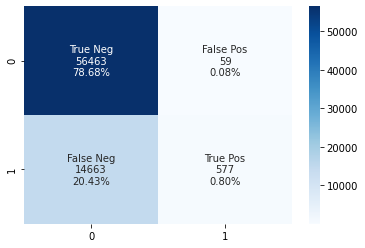

In [91]:
# predict the labels on validation dataset
predictions = result_xgb.predict(X_test) 
# Get & plot the confusion matrix
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

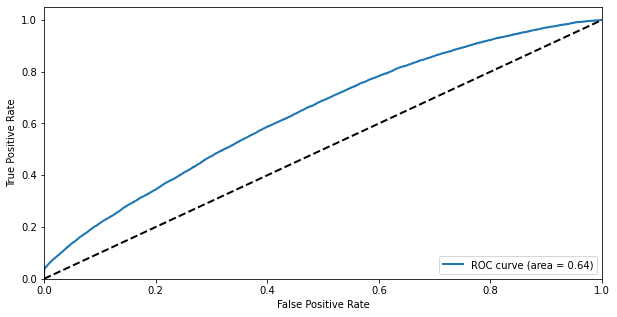

In [132]:
# AUC-ROC curve
predicted_probs_xgb = result_xgb.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, predicted_probs_xgb[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (10,5))
plt.plot(fpr, tpr, lw=2, label= 'ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### 5. f. Models Summary
- Through randomized grid search, logistic regression gave a best score of **0.7877** using hyperparameter combination of **{'C': 0.008301451461243866, 'penalty': 'none', 'solver': 'newton-cg'}**. Test score is **0.7876**
- Through randomized grid search, RandomForestClassifier gave a best score of **0.7935** using hyperparameter combination of **{'n_estimators': 80, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}**. Test score is **0.7944**
- Through randomized grid search, XGBClassifier gave a best score of **0.794** using hyperparameter combination of **{'subsample': 0.9, 'silent': False, 'reg_lambda': 50.0, 'n_estimators': 100, 'min_child_weight': 7.0, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.25, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4}**. Test score is **0.7948**
- More or less all the models are performing somewhat similar on the created dataset

### 5. g. Prediction on new dataset

In [46]:
y_new = result_xgb.predict(test_data)

In [47]:
replace = {True: 'Yes', False: 'No'}
df = pd.DataFrame({'predictions': y_new})
df['predictions'] = df['predictions'].apply(lambda x: replace[x])
df.to_csv('predictions.csv', index=False)

## 6. Synopsis
- We started with exploratory data analysis and also build some visualizations to understand the underlying data
- Before moving into text modeling we performed data preprocessing steps like removing null values, text processing steps like stopword removal, punctuation removal & lemmatization
- We used the consumer complaint narrative to predict the type of product the consumer identified in the complaint. For example, “Checking or savings account” or “Student loan.” We tried 3 classifiers out of which **Logistic Regression** outperformed other models with an accuracy score of around **0.93** and hence saw the confusion matrix & AUC-ROC curve for the same
- For next modeling, we performed data preprocessing steps like imputing null values, encoding; feature engineering to create new dataset for modeling; splitting & scaling the new dataset 
- We finally built some models to predict whether the consumer will dispute the resolution of the complaint or not. All the 3 models gave somewhat similar results after hyperparameter tuning and chose **XGBoost Classifier** with a test score of **0.795** to see the confusion matrix and AUC-ROC curve